In [51]:
import sys
sys.path.append('../src')
import numpy as np
import rebound
import matplotlib.pyplot as plt
import astropy.constants as const
from lightcurve import LightCurve
from ttv import TransitTimingVariations

# Two Planet Code Test

## Run Simulation with Variable Timestep
Two planet simulation is ran and the TTV curve of the object is calculated in the following code. Here, we use the parameters of Kepler-24 system using planets Kepler-24b and Kepler-24c

### Setup Parameters
First, we setup the simulation parameters

In [52]:
'''
Setup Simulation Parameters
'''
# Create a simulation
sim = rebound.Simulation()

# Set up units
sim.units = ('AU', 's', 'Msun')


# Define the timesteps 
# In this case both are the same as there will be no variable timestep for the first run
large_dt = 1e3
small_dt = 1e1

# Set the total simulation time
year = 60*60*24*365.25 # seconds/year
t_total = 4*year

Next, we setup the objects for simulation

In [53]:
'''
Set Up Objects for Simulation
'''
# Names of objects
names = ["Kepler-128","Kepler-128b","Kepler-128c"]

# Add the Star
sim.add(m=1.18,hash=names[0])


# 
# Add Kepler-24b
sim.add(m=0.0001275876, P=15.090*60*60*24,hash=names[1])

# Add Kepler-24c
sim.add(m=0.000098604, P=22.801*60*60*24,hash=names[2])

# Radii of planets
radii = np.array([180.95665,1.13,1.13]) 

This sets up the variable timestep parameters

In [54]:
'''
Set up Parameters for Variable Timestep in Simulation
'''
# Retrieve star radius
s_radius = radii[0]

# Find largest radius from planets
max_planet_radius = max(radii[1:])

# Add a buffer to this radius therefore the smaller timestep occurs before/after transit begins/ends
buffer = 10
max_planet_radius += buffer

# Define the entering and exiting transit region and ensure units are in AU (match simulation units)
entering = (-s_radius-max_planet_radius)  * const.R_earth.value/const.au.value
exiting = (s_radius+max_planet_radius)  * const.R_earth.value/const.au.value

### Run the simulation

In [55]:
'''
Run the Simulation
'''
# Create arrays to store positions and time
positions_x = []
positions_y = []
time = []
sim.move_to_com()
# Integrate the simulation until total time
while sim.t<=t_total:
    # Set timestep to large dt unless planet is in transit region
    dt = large_dt

    # Record positions
    positions_x.append(np.array([p.x for p in sim.particles]))
    positions_y.append(np.array([p.y for p in sim.particles]))

    # Retrieve position of planets
    planet_pos = positions_y[-1][1:]
    in_transit = np.logical_and(planet_pos>entering, planet_pos<exiting)
    
    # If any planet is in the transit region use a smaller timestep
    if np.sum(in_transit)>=1:
        if np.any(positions_x[-1][1:][in_transit]>0):
            dt = small_dt

    sim.dt=dt
    time.append(sim.t+sim.dt)
    sim.integrate(sim.t+sim.dt)

In [56]:
# Convert everything back to numpy array
positions_x = np.array(positions_x)
positions_y = np.array(positions_y)
time = np.array(time)


Plot the orbit

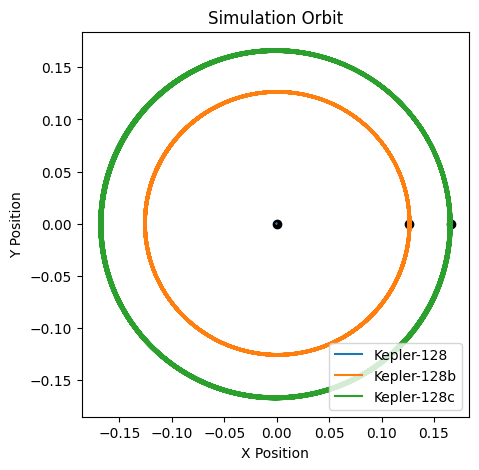

In [57]:
# Plot orbit
plt.figure(figsize=(5,5))
for i in range(len(radii)):
    plt.plot(positions_x[0,i],positions_y[0,i],c='k',ls='none',marker='o')
    plt.plot(positions_x[:,i],positions_y[:,i],label=names[i])
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Simulation Orbit")
plt.legend()

### Create lightcurves for object

In [58]:
LC = LightCurve(radii_objects=radii,rad_unit="REarth",dist_unit="AU",xgrid=time)
objects = LC.compute_lightcurve(positions_x.copy(),positions_y.copy(),names)
fig = LC.plot_total_lc(objects,sizex=18,sizey=5)

### Compute TTVs for Kepler-24b

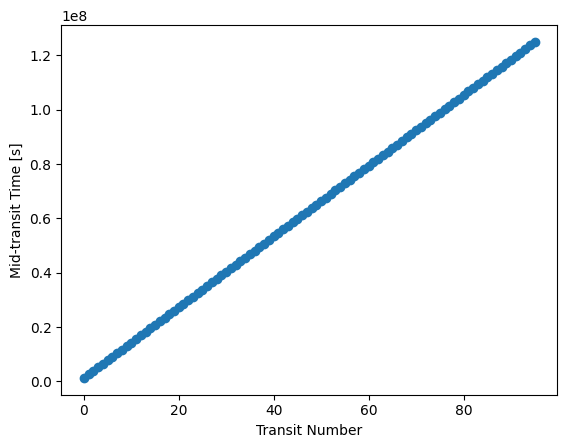

In [60]:
TTVinit_b = TransitTimingVariations(objects,1e3,names[1])

# First we calculate the mid transit times
MTTs_b = TTVinit_b.compute_MTTs(plotfig=True,method="interpolate")

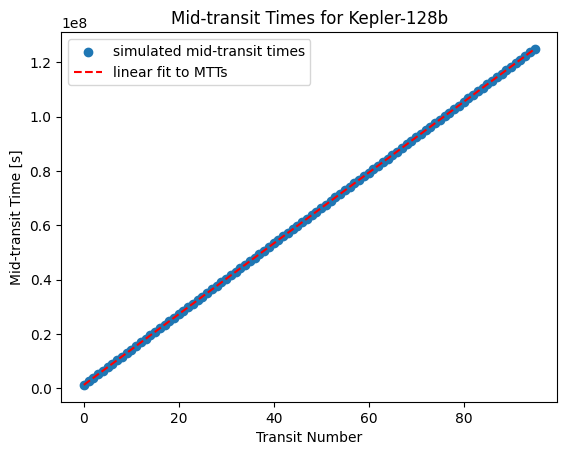

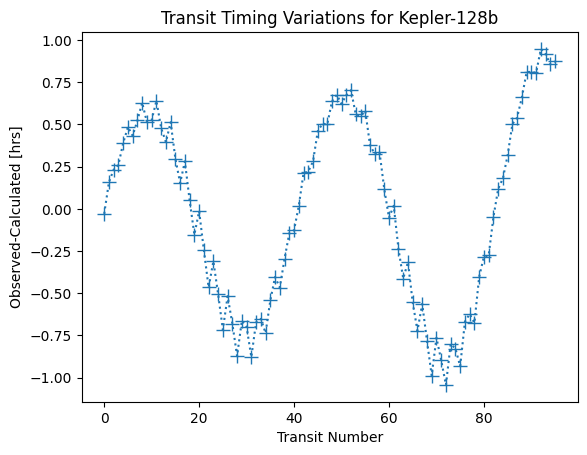

In [61]:
# Then we find the TTV curve
TTVs_b = TTVinit_b.compute_TTVs(plotfig=True,plot_time_units="hrs")

# Compute TTVs for Kepler-24c

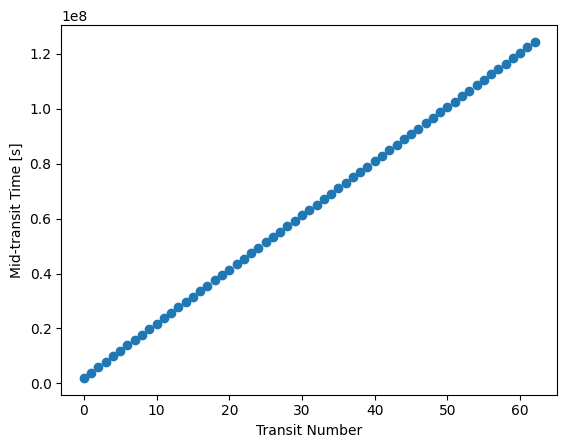

In [62]:
TTVinit_c = TransitTimingVariations(objects,1e3,names[2])

# First we calculate the mid transit times
MTTs_c = TTVinit_c.compute_MTTs(plotfig=True,method="interpolate")

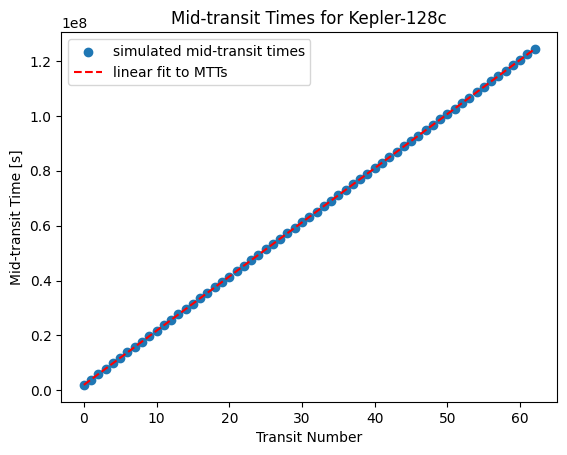

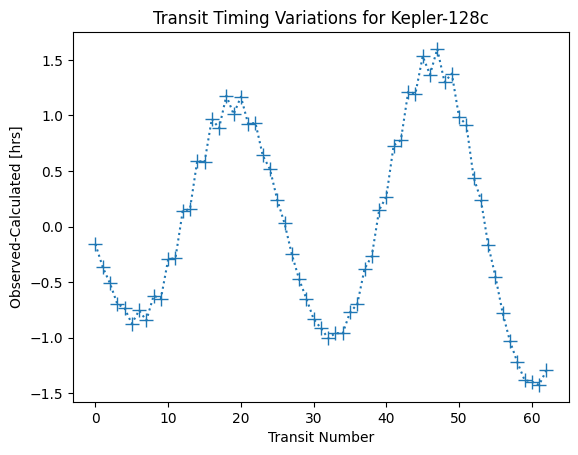

In [63]:
# Then we find the TTV curve
TTVs_c = TTVinit_c.compute_TTVs(plotfig=True,plot_time_units="hrs")

# Fit Sine Curves to TTV Data

In [64]:
from scipy.optimize import curve_fit

def sine_fit(t, y):
    # Define the sine function to fit
    def sine_function(t, A, omega, phi, offset):
        return A * np.sin(omega * t + phi) + offset

    # Initial guess for the parameters
    initial_guess = (max(y), 2.0 * np.pi / (max(t) - min(t))*2, 0.0, 0.0)
    print(initial_guess)
    # Use curve_fit to find the best-fit parameters
    params, covariance = curve_fit(sine_function, t, y, p0=initial_guess)
    print(params)
    # Generate the best-fit y-values using the fitted parameters
    y_fit = sine_function(t, *params)

    return y_fit
sine_c = sine_fit(MTTs_c/60/60/24,TTVs_c/60)
sine_b = sine_fit(MTTs_b/60/60/24,TTVs_b/60)


(95.92249042913318, 0.008871334520176539, 0.0, 0.0)
[-7.09299027e+01  1.01382941e-02  6.73891997e-02  7.69523329e+00]
(56.825175546109676, 0.008780094918418404, 0.0, 0.0)
[ 4.60612749e+01  1.00697919e-02  2.39043360e-02 -4.74032673e+00]


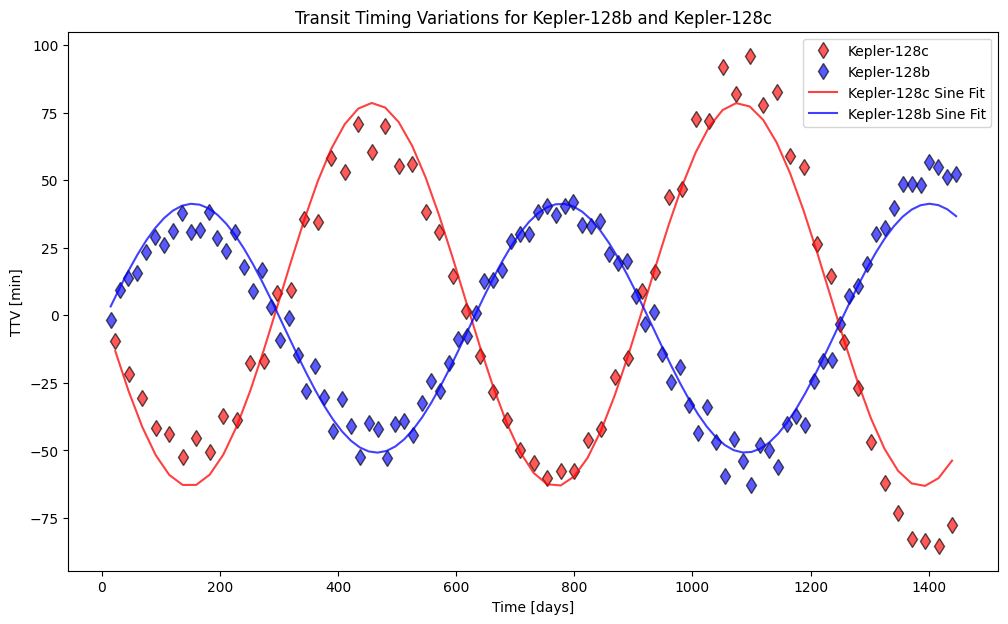

In [65]:
plt.figure(figsize=(12,7))
plt.plot(MTTs_c/60/60/24,TTVs_c/60,ls="",marker='d',ms=8,c="r",label=names[2],alpha=0.65,markeredgecolor="k")
plt.plot(MTTs_b/60/60/24,TTVs_b/60,ls='',marker='d',ms=8,c="b",label=names[1],alpha=0.65,markeredgecolor="k")
plt.plot(MTTs_c/60/60/24,sine_c,ls="-",c="r",label=names[2]+" Sine Fit",alpha=0.75)
plt.plot(MTTs_b/60/60/24,sine_b,ls='-',c="b",label=names[1]+" Sine Fit",alpha=0.75)
plt.title("Comparing TTV Curve for One Planet With and Without the Variable Timestep")
plt.xlabel('Time [days]')
plt.ylabel('TTV [min]')
plt.title('Transit Timing Variations for '+names[1]+' and '+names[2])
plt.legend()



plt.savefig("two_planet.pdf")
plt.show()